# Assignment 4 - Chatbots

#### Steve Desilets

#### August 26, 2023

## 1) Chatbot 1 - Sentence-Based Transformer Chatbot That Leverages Cosine Similarity

In [2]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer
import random
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


from IPython.display import display, HTML

from typing import List, Callable, Dict, Tuple, Set

pd.set_option('max_colwidth', 600)
pd.set_option('display.max_rows', 500)

In [58]:
#Load Sentence Transformer model optimized for  sentence cosine similarity calculations

#The models below fully downloaded in Google Colab. This is the version of the google colab notebook but 
#it was open in anoconda to be saved as pdf and the download graphics did not transfer properly so 
#it seems like it didn't download. However, it did in the orignal google colab notebook, where all the
#analysis was run.

model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [59]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [3]:
#read in data
CORPUS_PATH = 'C:/Users/steve/OneDrive/Desktop/Github/Natural_Language_Processing/Chatbot Assignment/coral_reef_fish.txt'
f=open(CORPUS_PATH,'r',errors = 'ignore')
raw=f.read()
raw=raw.lower()# converts to lowercase

#create list of sentences and words
sent_tokens = nltk.sent_tokenize(raw)# converts to list of sentences 
word_tokens = nltk.word_tokenize(raw)# converts to list of words

In [61]:
#create greetings and greetings function

GREETING_INPUTS = ("hello", "hi", "greetings", "sup", "what's up","hey",)
GREETING_RESPONSES = ["Hello"]


# Checking for greetings
def greeting(sentence):
    """If user's input is a greeting, return a greeting response"""
    for word in sentence.split():
        if word.lower() in GREETING_INPUTS:
            return random.choice(GREETING_RESPONSES)

In [62]:

# Generating response function 
def response(user_response):
    chatbot_response=''
    sentence_encodings=model.encode(sent_tokens, convert_to_tensor=True)# generate sentence transformer embeddings
    sentence_encodings=sentence_encodings.cpu()
    vals = cosine_similarity(sentence_encodings[-1].reshape(1, -1), sentence_encodings) #the chatbot conversation code 
    #in the next cell adds the question as the last sentence of the sentence tokens, before calling this response function.
    #The code takes the last sentence (which is the question) and gets cosine similarities vs all the sentences in the corpus,
    #including itself
    idx=vals.argsort()[0][-2] #gets the index of the second highest similarity (the first highest would be the question itself)
    flat = vals.flatten()#reduces dimension of cosine similarity array to be able to sort
    flat.sort() #sort the cosine similarity values
    second_cos_sim_val = flat[-2] #get the second highest cosine similarity value.
    if(second_cos_sim_val==0): #check the second highest cosine similarity value. If it's zero return the no match response,
        #else return highest cosine similarity sentence.
        chatbot_response=chatbot_response+"Sorry, I do not have an answer to your question in my database"
        return chatbot_response
    else:
        chatbot_response = chatbot_response+sent_tokens[idx] #use index of highest cosine similarity to get original sentence
        return chatbot_response

In [63]:
#Chatbot interaction code

flag=True
print("Welcome to the Informational Chatbot About Coral Reef Fish. To end session please type exit.")
print("\n")

while(flag==True):
    user_response = input()
    user_response=user_response.lower()
    if user_response!='exit':
        if(user_response=='thanks' or user_response=='thank you' ):
            flag=False
            print("Answer: You are welcome!")
        else:
            if(greeting(user_response)!=None):
                print("Answer: "+greeting(user_response))
            else:
                sent_tokens.append(user_response)
                word_tokens=word_tokens+nltk.word_tokenize(user_response)
                final_words=list(set(word_tokens))
                print("Answer: ",end="")
                print(response(user_response))
                print("\n")
                sent_tokens.remove(user_response)
    else:
        flag=False
        print("Thank you for using the Informational Chatbot About Coral Reef Fish. Goodbye.")    


Welcome to the Informational Chatbot About Coral Reef Fish. To end session please type exit.


Which species is blue?
Answer: the psychedelic synchiropus splendidus is one of only two animal species known to have blue colouring because of cellular pigment.


What is the slowest species that lives in coral reefs?
Answer: the slowest-moving fishes are the sea horses, often found in reefs.




KeyboardInterrupt: Interrupted by user

In [85]:
chatbot_models = []

for i in range(20):
    chatbot_models.append(1)
    
model_1_performance_list = ["Incorrect",
                          "Correct",
                          "Correct",
                          "Incorrect",
                          "Incorrect",
                          "Incorrect",
                          "Correct",
                          "Incorrect",
                          "Incorrect",
                          "Incorrect",
                          "Partially Correct",
                          "Correct",
                          "Incorrect",
                          "Incorrect",
                          "Incorrect",
                          "Incorrect",
                          "Correct",
                          "Incorrect",
                           "Correct",
                           "Correct"]

## 2) Chatbot 2 - Fine-Tune GPT2 Model

In [9]:
!pip install transformers

In [11]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW

# Load the GPT-2 model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
# Define multiple question and answer pairs
qa_pairs = [
    ("Which species are at the top of the food chain?", "sharks and giant moray. STOP"),
    ("What fish eat coral?", "parrotfish and butterflyfish. STOP"),
    ("Which coral reef fish has the shortest lifespan?", "seven-figure pygmy goby. STOP"),
    ("What species can inflate themselves?", "puffers, striated frogfish, and porcupinefish. STOP"),
    ("How do sea anemones protect themselves?", "the tentacles of sea anemones bristle with tiny harpoons (nematocysts) primed with toxins, and are an effective deterrent against most predators. STOP"),
    ("What species commonly serves as a cleaner fish?", "bluestreak cleaner wrasse. STOP"),
    ("What species eat sponges?", "emperor angelfish. STOP"),
    ("What species eat stingrays?", "caribbean reef shark and great hammerheads. STOP"),
    ("Which species are hermaphrodites", "grouper. STOP"),
    ("What species is known to eat birds?", "blacktip reef shark. STOP")
]

# Concatenate the question and answer pairs with appropriate formatting
formatted_pairs = [f"Q: {q}\nA: {a}\n" for q, a in qa_pairs]
qa_text = "\n".join(formatted_pairs)

# Fine-tune the GPT-2 model with the Q&A pairs
inputs = tokenizer.encode(qa_text, return_tensors="pt")
model.train()

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Run the fine-tuning loop (example: 1 epoch)
for j in range(120):
    print (j)
    outputs = model(inputs, labels=inputs)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# Save the fine-tuned model
model.save_pretrained("fine-tuned-gpt2")

# Load the fine-tuned model
fine_tuned_model = GPT2LMHeadModel.from_pretrained("fine-tuned-gpt2")



C:\Users\steve\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


In [14]:
# Test the fine-tuned model with a question
test_question = "Q: How many species of fish live in coral reefs?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: How many species of fish live in coral reefs?', 'A: About 1,000 species of coral reef fish live in the United States. These fish are an important food source for many species of birds and other marine life. However, coral reef fish are an invasive species and are an invasive species throughout the United States. What species are at the top of the food chain?']


In [15]:
# Test the fine-tuned model with a question
test_question = "Q: What is the most venomous fish?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What is the most venomous fish?', 'A: parrotfish and butterflyfish. Parrotfish are the most venomous fish in the world, and are the most venomous fish in the world. Butterflyfish are the most venomous fish in the world, and are the most venomous fish in the world.']


In [16]:
# Test the fine-tuned model with a question
test_question = "Q: What sharks live in coral reefs?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What sharks live in coral reefs?', 'A: sharks and giant moray. ']


In [17]:
# Test the fine-tuned model with a question
test_question = "Q: What fish are poisonous?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What fish are poisonous?', 'A: sharks and giant moray. ']


In [18]:
# Test the fine-tuned model with a question
test_question = "Q: What fish can electrocute you?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What fish can electrocute you?', 'A: sharks and giant moray. ']


In [19]:
# Test the fine-tuned model with a question
test_question = "Q: What species can sting you?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What species can sting you?', 'A: sharks and giant moray. ']


In [20]:
# Test the fine-tuned model with a question
test_question = "Q: What species are parasitic?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What species are parasitic?', 'A: sharks and giant moray. ']


In [21]:
# Test the fine-tuned model with a question
test_question = "Q: What species are venomous?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What species are venomous?', 'A: sharks and giant moray. ']


In [22]:
# Test the fine-tuned model with a question
test_question = "Q: What species are known for attacking scuba divers?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What species are known for attacking scuba divers?', 'A: sharks and giant moray. ']


In [23]:
# Test the fine-tuned model with a question
test_question = "Q: What are common herbivorous fish?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What are common herbivorous fish?', 'A: puffers, striated frogfish, and porcupinefish. They are great at eating invertebrates, and are an excellent source of vitamin A. They are an excellent source of calcium, and are an excellent source of iron.']


In [24]:
# Test the fine-tuned model with a question
test_question = "Q: Why do fish camouflage themselves?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: Why do fish camouflage themselves?', 'A: Because fish camouflage themselves. They are the most effective predators on land. They are the most effective predators on fish. They are the most effective predators on birds. They are the most effective predators on fish. They are the most effective predators on fish. They are the most effective predators on fish. They are the most effective predators on fish. They are the most effective predators on fish. They are the most effective predators on fish. They are the']


In [25]:
# Test the fine-tuned model with a question
test_question = "Q: How do fish get rid of their parasites?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: How do fish get rid of their parasites?', 'A: Fish eat parasites, and fish eat fish. Fish eat parasites because fish eat parasites. Fish eat fish because fish eat parasites. Fish eat fish because fish eat parasites. Fish eat fish because fish eat parasites. Fish eat fish because fish eat parasites. Fish eat fish because fish eat parasites. Fish eat fish because fish eat parasites. Fish eat fish because fish eat parasites. Fish eat fish because fish eat parasites. Fish eat fish because fish']


In [26]:
# Test the fine-tuned model with a question
test_question = "Q: What species have a mutualistic relationship?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What species have a mutualistic relationship?', 'A: sharks and giant moray. ']


In [27]:
# Test the fine-tuned model with a question
test_question = "Q: What species have a commensalistic relationship?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What species have a commensalistic relationship?', 'A: sharks and giant moray. ']


In [28]:
# Test the fine-tuned model with a question
test_question = "Q: Where in the world are coral reefs found?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: Where in the world are coral reefs found?', 'A: Coral reefs are the largest coral reef in the world. They are the largest coral reef in the world because of their size and because of their ability to withstand the elements. They are the most abundant coral reef fish in the world. They are an important food source for birds, and are an important food source for sea anemones. They are an excellent predator for fish and are an excellent finisher for reef fish.']


In [29]:
# Test the fine-tuned model with a question
test_question = "Q: What species engage in schooling?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What species engage in schooling?', 'A: sharks and giant moray. ']


In [30]:
# Test the fine-tuned model with a question
test_question = "Q: What species are ambush predators?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What species are ambush predators?', 'A: sharks and giant moray. ']


In [32]:
# Test the fine-tuned model with a question
test_question = "Q: Which species are ambush predators?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: Which species are ambush predators?', 'A: sharks and giant moray. ']


In [31]:
# Test the fine-tuned model with a question
test_question = "Q: Why are some coral reef fish colorful?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: Why are some coral reef fish colorful?', 'A: Coral reef fish are known to eat fish, and are an effective deterrent against most predators. However, coral reef fish are also known to eat stingrays, which are an effective deterrent against most predators.']


In [33]:
# Test the fine-tuned model with a question
test_question = "Q: Which species is blue?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: Which species is blue?', 'A: sharks and giant moray. ']


In [34]:
# Test the fine-tuned model with a question
test_question = "Q: What is the slowest species that lives in coral reefs?"

# Generate a completion for the test question
input_ids = tokenizer.encode(test_question, return_tensors="pt")
output = fine_tuned_model.generate(input_ids, max_length=100)
completion = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated completion for the test question:")
print(completion.split("STOP")[0].splitlines()[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated completion for the test question:
['Q: What is the slowest species that lives in coral reefs?', 'A: sharks and giant moray. ']


In [86]:
for i in range(20):
    chatbot_models.append(2)
    
    
model_2_performance_list = ["Partially Correct",
                          "Incorrect",
                          "Incorrect",
                          "Partially Correct",
                          "Incorrect", 
                          "Incorrect",
                          "Incorrect",
                          "Incorrect",
                          "Partially Correct",
                          "Incorrect",
                          "Incorrect",
                          "Partially Correct",
                          "Incorrect",
                          "Incorrect",
                          "Incorrect",
                          "Incorrect",
                          "Incorrect",
                          "Incorrect",
                          "Incorrect",
                           "Incorrect"]


## 3) Chatbot 3 - Chatbot Emphasizing Cosine Similarity of TF-IDF Representations of Sententces

In [35]:
import io
import random
import string # to process standard python strings
import warnings
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [36]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('popular', quiet=True) # for downloading packages
#nltk.download('punkt') # first-time use only
#nltk.download('wordnet') # first-time use only

True

In [37]:
CORPUS_PATH = 'C:/Users/steve/OneDrive/Desktop/Github/Natural_Language_Processing/Chatbot Assignment/coral_reef_fish.txt'
f=open(CORPUS_PATH,'r',errors = 'ignore')
raw=f.read()
raw = raw.lower()# converts to lowercase

In [38]:
sent_tokens = nltk.sent_tokenize(raw)# converts to list of sentences 
word_tokens = nltk.word_tokenize(raw)# converts to list of words

In [39]:
lemmer = nltk.stem.WordNetLemmatizer()
#WordNet is a semantically-oriented dictionary of English included in NLTK.
def LemTokens(tokens):
    return [lemmer.lemmatize(token) for token in tokens]
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [40]:
GREETING_INPUTS = ("hello", "hi", "greetings", "sup", "what's up","hey",)
GREETING_RESPONSES = ["Hi", "Hey", "*nods*", "Hi there", "Hello", "I am glad! You are talking to me"]
def greeting(sentence):
 
    for word in sentence.split():
        if word.lower() in GREETING_INPUTS:
            return random.choice(GREETING_RESPONSES)

In [41]:
def response(user_response):
    robo_response=''
    sent_tokens.append(user_response)
    TfidfVec = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english')
    tfidf = TfidfVec.fit_transform(sent_tokens)
    vals = cosine_similarity(tfidf[-1], tfidf)
    idx=vals.argsort()[0][-2]
    flat = vals.flatten()
    flat.sort()
    req_tfidf = flat[-2]
    if(req_tfidf==0):
        robo_response=robo_response+"I am sorry! I don't understand you"
        return robo_response
    else:
        robo_response = robo_response+sent_tokens[idx]
        return robo_response

In [42]:
flag=True
print("Hello, I am the Third Coral Reef Chatbot! I will answer your queries related to coral reef fish. If you want to exit, type Bye!")
while(flag==True):
    user_response = input()
    user_response=user_response.lower()
    if(user_response!='bye'):
        if(user_response=='thanks' or user_response=='thank you' ):
            flag=False
            print("You are welcome.")
        else:
            if(greeting(user_response)!=None):
                print(greeting(user_response))
            else:
                print("",end="")
                print(response(user_response))
                sent_tokens.remove(user_response)
    else:
        flag=False
        print("Bye! take care..")

Hello, I am the Third Coral Reef Chatbot! I will answer your queries related to coral reef fish. If you want to exit, type Bye!
How many species of fish live in coral reefs?
 coral reef fish are fish which live amongst or in close relation to coral reefs.
What is the most venomous fish?
 there is a distinction between poisonous fish and venomous fish.
What sharks live in coral reefs?
 coral reef fish are fish which live amongst or in close relation to coral reefs.
What fish are poisonous?
 there is a distinction between poisonous fish and venomous fish.
What fish can electrocute you?
 as with all fish, coral reef fish harbour parasites.
What species can sting you?
 in return, the anemones provide the clownfish protection from their predators, who are not immune to anemone stings.
What species are venomous?
 the most venomous known fish is the reef stonefish.
What species are parasitic?
 parasites of coral reef fish include nematodes, platyhelminthes (cestodes, digeneans, and monogenean

In [87]:

for i in range(20):
    chatbot_models.append(3)

model_3_performance_list = ["Incorrect",
                          "Incorrect", 
                          "Incorrect",
                          "Incorrect",
                          "Incorrect",
                          "Correct",
                          "Correct",
                          "Correct",
                          "Correct",
                          "Incorrect",
                          "Partially Correct",
                          "Incorrect",
                          "Correct",
                          "Incorrect",
                          "Partially Correct",
                          "Correct",
                          "Correct",
                          "Incorrect",
                           "Correct",
                           "Incorrect"]


## 4) Chatbot 4 - Distillbert

Source: https://huggingface.co/distilbert-base-cased-distilled-squad

In [4]:
#read in data
CORPUS_PATH = 'C:/Users/steve/OneDrive/Desktop/Github/Natural_Language_Processing/Chatbot Assignment/coral_reef_fish.txt'
f=open(CORPUS_PATH,'r',errors = 'ignore')
raw=f.read()
raw=raw.lower()# converts to lowercase

In [8]:
from transformers import pipeline
question_answerer = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')

#context = r"""
#Extractive Question Answering is the task of extracting an answer from a text given a question. An example     of a
#question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
#a model on a SQuAD task, you may leverage the examples/pytorch/question-answering/run_squad.py script.
#"""

result = question_answerer(question="What is a good example of a question answering dataset?",     context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

#Answer: 'SQuAD dataset', score: 0.5152, start: 147, end: 160

C:\Users\steve\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\steve\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Answer: 'the great hammerhead uses its hammer', score: 0.0377, start: 34598, end: 34634


In [9]:
result = question_answerer(question="How many species of fish live in coral reefs?",     context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'four', score: 0.6391, start: 17258, end: 17262


In [10]:
result = question_answerer(question="What is the most venomous fish?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'reef stonefish', score: 0.8257, start: 24899, end: 24913


In [11]:
result = question_answerer(question="What sharks live in coral reefs?",     context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'whitetip reef shark', score: 0.8656, start: 34283, end: 34302


In [12]:
result = question_answerer(question="What fish are poisonous?",     context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'coral reef fish', score: 0.8148, start: 0, end: 15


In [13]:
result = question_answerer(question="What fish can electrocute you?",     context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'snapper', score: 0.3421, start: 11139, end: 11146


In [14]:
result = question_answerer(question="What species can sting you?",     context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'yellow stingrays', score: 0.6958, start: 34108, end: 34124


In [15]:
result = question_answerer(question="What species are parasitic?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'coral reef fish', score: 0.5431, start: 0, end: 15


In [16]:
result = question_answerer(question="What species are venomous?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'spinefoot rabbitfish', score: 0.9286, start: 18449, end: 18469


In [17]:
result = question_answerer(question="What species are known for attacking scuba divers?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'lionfish', score: 0.9109, start: 26369, end: 26377


In [18]:
result = question_answerer(question="What are common herbivorous fish?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'yellow tang', score: 0.5247, start: 2116, end: 2127


In [19]:
result = question_answerer(question="Why do fish camouflage themselves?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'when the fish rests in places with the right background', score: 0.7476, start: 6715, end: 6770


In [20]:
result = question_answerer(question="How do fish get rid of their parasites?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'by biting, stinging, or stabbing', score: 0.4523, start: 23987, end: 24019


In [21]:
result = question_answerer(question="What species have mutualistic relationships?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'sea anemones and clownfish', score: 0.8657, start: 21835, end: 21861


In [22]:
result = question_answerer(question="What species have commensalistic relationships?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'sea anemones and clownfish', score: 0.6863, start: 21835, end: 21861


In [23]:
result = question_answerer(question="Where in the world are coral reefs found?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'top predators', score: 0.8029, start: 26812, end: 26825


In [24]:
result = question_answerer(question="What species engage in schooling?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'spinefoot rabbitfish', score: 0.6337, start: 19619, end: 19639


In [25]:
result = question_answerer(question="Which species are ambush predators?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'frogfish', score: 0.5638, start: 9688, end: 9696


In [26]:
result = question_answerer(question="Why are some coral reef fish colorful?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'high biodiversity', score: 0.7926, start: 22542, end: 22559


In [27]:
result = question_answerer(question="Which species is blue?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'bluestripe snapper', score: 0.6375, start: 12029, end: 12047


In [28]:
result = question_answerer(question="What is the slowest species that lives in coral reefs?", context=raw)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'dwarf seahorse', score: 0.4608, start: 4939, end: 4953


In [88]:

for i in range(20):
    chatbot_models.append(4)

model_4_performance_list = ["Incorrect",
                          "Correct",
                           "Correct",
                           "Incorrect",
                           "Incorrect",
                           "Correct",
                           "Incorrect",
                           "Correct",
                           "Correct",
                           "Correct",
                           "Incorrect",
                           "Incorrect",
                           "Correct",
                           "Incorrect",
                           "Incorrect",
                           "Correct",
                           "Correct",
                           "Incorrect",
                           "Partially Correct",
                           "Correct"]

## 5) Chatbot 5 - Roberta

https://huggingface.co/deepset/roberta-base-squad2

In [46]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline, RobertaTokenizer, RobertaModel, TFRobertaModel
from transformers import optimization

batch_size = 96
n_epochs = 2
base_LM_model = "roberta-base"
max_seq_len = 386
learning_rate = 3e-5
#lr_schedule = optimization.LinearWarmup
warmup_proportion = 0.2
doc_stride=128
max_query_length=64

In [50]:
#!pip install farm-haystack[inference]

  Obtaining dependency information for farm-haystack[inference] from https://files.pythonhosted.org/packages/df/ef/485cd648ee02afafd5c014b609c214299507112c246b75303f91fd2c139f/farm_haystack-1.19.0-py3-none-any.whl.metadata
  Obtaining dependency information for canals==0.3.2 from https://files.pythonhosted.org/packages/b8/f6/6d2071a20400129a72390f021b46603f694d29553df0725152864c3c40f3/canals-0.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for events from https://files.pythonhosted.org/packages/25/ed/e47dec0626edd468c84c04d97769e7ab4ea6457b7f54dcb3f72b17fcd876/Events-0.5-py3-none-any.whl.metadata
  Obtaining dependency information for more-itertools from https://files.pythonhosted.org/packages/5a/cb/6dce742ea14e47d6f565589e859ad225f2a5de576d7696e0623b784e226b/more_itertools-10.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for platformdirs from https://files.pythonhosted.org/packages/14/51/fe5a0d6ea589f0d4a1b97824fb518962ad48b27cd346dcdfa2405187997a/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
google-api-core 1.25.1 requires google-auth<2.0dev,>=1.21.1, but you have google-auth 2.18.1 which is incompatible.
google-cloud-core 1.7.1 requires google-auth<2.0dev,>=1.24.0, but you have google-auth 2.18.1 which is incompatible.
google-cloud-storage 1.31.0 requires google-auth<2.0dev,>=1.11.0, but you have google-auth 2.18.1 which is incompatible.
tensorboard 2.12.3 requires tensorboard-data-server<0.8.0,>=0.7.0, but you have tensorboard-data-server 0.6.1 which is incompatible.
tensorflow-intel 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 4.21.0 which i

     ---------------------------------------- 48.7/48.7 kB ? eta 0:00:00
  Obtaining dependency information for scikit-learn>=1.3.0 from https://files.pythonhosted.org/packages/2d/30/3afb8bcb785653254eb646ff2680ec4d637b40b06f4b046aca17b5e086b0/scikit_learn-1.3.0-cp39-cp39-win_amd64.whl.metadata
     -------------------------------------- 635.6/635.6 kB 8.0 MB/s eta 0:00:00
  Obtaining dependency information for requests from https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl.metadata
  Obtaining dependency information for accelerate>=0.20.3 from https://files.pythonhosted.org/packages/4d/a7/05c67003d659a0035f2b3a8cf389c1d9645865aee84a73ce99ddab16682f/accelerate-0.22.0-py3-none-any.whl.metadata
  Obtaining dependency information for cattrs>=22.2 from https://files.pythonhosted.org/packages/3a/ba/05df14efaa0624fac6b1510e87f5ce446208d2f6ce50270a89b6268aebfe/cattrs-23.1.2-py3-none-any.whl.metadata
  Ob

In [61]:
#from haystack.reader.farm import FARMReader

#reader = TransformersReader(model_name_or_path="deepset/roberta-base-squad2",tokenizer="deepset/roberta-base-squad2")

model_name = "deepset/roberta-base-squad2"

# a) Get predictions
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
QA_input = {
    'question': 'How many species of fish live in coral reefs?',
    'context': raw
}
res = nlp(QA_input)

# b) Load model & tokenizer
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

res

{'score': 0.28468453884124756,
 'start': 3244,
 'end': 3257,
 'answer': '6,000â€“8,000'}

In [62]:
# a) Get predictions
QA_input = {
    'question': 'What is the most venomous fish?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.612525463104248,
 'start': 24899,
 'end': 24913,
 'answer': 'reef stonefish'}

In [64]:
# a) Get predictions
QA_input = {
    'question': 'What sharks live in coral reefs?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.1773730218410492,
 'start': 28108,
 'end': 28128,
 'answer': 'caribbean reef shark'}

In [65]:
# a) Get predictions
QA_input = {
    'question': 'What fish are poisonous?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.5669053196907043,
 'start': 23682,
 'end': 23696,
 'answer': 'many reef fish'}

In [66]:
# a) Get predictions
QA_input = {
    'question': 'What fish can electrocute you?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.010173969902098179,
 'start': 9045,
 'end': 9062,
 'answer': 'clown triggerfish'}

In [67]:
# a) Get predictions
QA_input = {
    'question': 'What species can sting you?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.5866654515266418,
 'start': 27273,
 'end': 27286,
 'answer': 'the stargazer'}

In [68]:
# a) Get predictions
QA_input = {
    'question': 'What species are parasitic?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.06776570528745651,
 'start': 17341,
 'end': 17353,
 'answer': 'damselfishes'}

In [69]:
# a) Get predictions
QA_input = {
    'question': 'What species are venomous?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.3828498125076294,
 'start': 27273,
 'end': 27286,
 'answer': 'the stargazer'}

In [70]:
# a) Get predictions
QA_input = {
    'question': 'What species are known for attacking scuba divers?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.005669948644936085,
 'start': 26369,
 'end': 26377,
 'answer': 'lionfish'}

In [71]:
# a) Get predictions
QA_input = {
    'question': 'What are common herbivorous fish?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.33974504470825195,
 'start': 2116,
 'end': 2127,
 'answer': 'yellow tang'}

In [72]:
# a) Get predictions
QA_input = {
    'question': 'Why do fish camouflage themselves?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.33112961053848267,
 'start': 8282,
 'end': 8309,
 'answer': 'lets them ambush their prey'}

In [73]:
# a) Get predictions
QA_input = {
    'question': 'How do fish get rid of their parasites?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.2778742015361786,
 'start': 16126,
 'end': 16153,
 'answer': 'establish cleaning stations'}

In [74]:
# a) Get predictions
QA_input = {
    'question': 'What species have mutualistic relationships?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.19288134574890137,
 'start': 21835,
 'end': 21861,
 'answer': 'sea anemones and clownfish'}

In [75]:
# a) Get predictions
QA_input = {
    'question': 'What species have commensalistic relationships?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.1290857344865799,
 'start': 0,
 'end': 15,
 'answer': 'coral reef fish'}

In [76]:
# a) Get predictions
QA_input = {
    'question': 'Where in the world are coral reefs found?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.11980749666690826,
 'start': 28031,
 'end': 28043,
 'answer': 'indo-pacific'}

In [77]:
# a) Get predictions
QA_input = {
    'question': 'What species engage in schooling?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.235614612698555,
 'start': 27273,
 'end': 27286,
 'answer': 'the stargazer'}

In [78]:
# a) Get predictions
QA_input = {
    'question': 'What species are ambush predators?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.5129007697105408,
 'start': 24899,
 'end': 24913,
 'answer': 'reef stonefish'}

In [79]:
# a) Get predictions
QA_input = {
    'question': 'Why are some coral reef fish colorful?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.09240982681512833,
 'start': 81,
 'end': 145,
 'answer': 'coral reefs form complex ecosystems with tremendous biodiversity'}

In [80]:
# a) Get predictions
QA_input = {
    'question': 'Which species is blue?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.4031549096107483,
 'start': 12029,
 'end': 12047,
 'answer': 'bluestripe snapper'}

In [81]:
# a) Get predictions
QA_input = {
    'question': 'What is the slowest species that lives in coral reefs?',
    'context': raw
}
res = nlp(QA_input)

res

{'score': 0.6155030727386475,
 'start': 4939,
 'end': 4953,
 'answer': 'dwarf seahorse'}

In [89]:

for i in range(20):
    chatbot_models.append(5)

model_5_performance_list = ["Correct",
                           "Correct",
                           "Correct",
                           "Partially Correct",
                           "Incorrect",
                           "Partially Correct",
                           "Partially Correct",
                           "Correct",
                           "Correct",
                           "Correct",
                           "Correct",
                           "Correct",
                           "Correct",
                           "Incorrect",
                           "Correct",
                           "Incorrect",
                           "Correct",
                           "Incorrect",
                           "Partially Correct",
                           "Correct"]

## 5) Evaluation of Results

In [90]:

import pandas as pd


chatbot_performance_df = pd.DataFrame({'Correct': [100 * model_1_performance_list.count("Correct")/len(model_1_performance_list),
                               100 * model_2_performance_list.count("Correct")/len(model_2_performance_list),
                               100 * model_3_performance_list.count("Correct")/len(model_3_performance_list),
                               100 * model_4_performance_list.count("Correct")/len(model_4_performance_list),
                               100 * model_5_performance_list.count("Correct")/len(model_5_performance_list)],
                    'Partially Correct': [100 * model_1_performance_list.count("Partially Correct")/len(model_1_performance_list),
                               100 * model_2_performance_list.count("Partially Correct")/len(model_2_performance_list),
                               100 * model_3_performance_list.count("Partially Correct")/len(model_3_performance_list),
                               100 * model_4_performance_list.count("Partially Correct")/len(model_4_performance_list),
                               100 * model_5_performance_list.count("Partially Correct")/len(model_5_performance_list)],
                   'Incorrect': [100 * model_1_performance_list.count("Incorrect")/len(model_1_performance_list),
                               100 * model_2_performance_list.count("Incorrect")/len(model_2_performance_list),
                               100 * model_3_performance_list.count("Incorrect")/len(model_3_performance_list),
                               100 * model_4_performance_list.count("Incorrect")/len(model_4_performance_list),
                               100 * model_5_performance_list.count("Incorrect")/len(model_5_performance_list)]},
                  index=['1', '2', '3', '4', '5'])



In [91]:
chatbot_performance_df

,Correct,Partially Correct,Incorrect
1,35.0,5.0,60.0
2,0.0,20.0,80.0
3,40.0,10.0,50.0
4,50.0,5.0,45.0
5,60.0,20.0,20.0


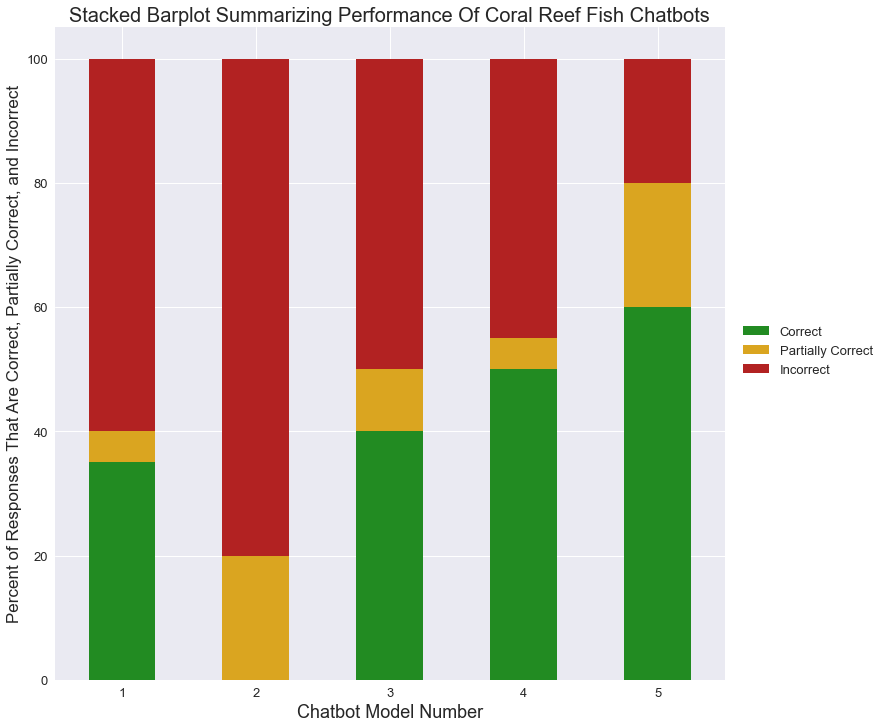

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

plt.style.use('seaborn')

ax = chatbot_performance_df.plot(kind = 'bar', stacked = True, figsize = (12, 12), fontsize = 13, color = ["forestgreen", "goldenrod", 'firebrick'])

ax.set_xticklabels(labels = ["1", "2", "3", "4", "5"], rotation = 0)
ax.set_xlabel("Chatbot Model Number", fontsize=18)
ax.set_ylabel("Percent of Responses That Are Correct, Partially Correct, and Incorrect", fontsize=17)
ax.set_title('Stacked Barplot Summarizing Performance Of Coral Reef Fish Chatbots', fontsize = 20)

plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, fontsize = 13)

plt.show();
